# Movie Viewer Clustering and Recommendation

For this unsupervised learning capstone, I will be using several of the clustering algorithms I learned in this module to augment a movie recommendations based on movie genres and viewer ratings.

The dataset I'm using includes movie title, genres, and viewer ratings: https://grouplens.org/datasets/movielens/). I also used data visualization functions found here: gist.github.com/Rhysoshea/18f4af800179a7fa53d29194ef4dca6f

In [115]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

#Read the data and take a peek
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [116]:
# Print the number of ratings and the total number of movies
print('The dataset contains: ' + str(len(ratings)) + ' ratings of ' + str(len(movies)) + ' movies.')

# Count number of movies per genre
from collections import Counter
l = [i.split('|') for i in list(movies.genres)]

flat_list = [item for sublist in l for item in sublist] 
c = Counter(flat_list)
c.most_common()

The dataset contains: 100836 ratings of 9742 movies.


[('Drama', 4361),
 ('Comedy', 3756),
 ('Thriller', 1894),
 ('Action', 1828),
 ('Romance', 1596),
 ('Adventure', 1263),
 ('Crime', 1199),
 ('Sci-Fi', 980),
 ('Horror', 978),
 ('Fantasy', 779),
 ('Children', 664),
 ('Animation', 611),
 ('Mystery', 573),
 ('Documentary', 440),
 ('War', 382),
 ('Musical', 334),
 ('Western', 167),
 ('IMAX', 158),
 ('Film-Noir', 87),
 ('(no genres listed)', 34)]

First I'll use the two most common movie genres, drama and comedy, and identify clusters in how viewer rated them. I'm starting only two genres for ease of visualizing the data in two dimensions. After I've built and tested my model on two genres, I'll increase the dimensionality by adding more. 

In [117]:
# Function to get the average genre ratings by user
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
    genre_ratings.columns = column_names
    return genre_ratings

# Get the average rating of drama and comedy movies
genre_ratings = get_genre_ratings(ratings, movies, ['Drama', 'Comedy'], ['avg_drm_rating', 'avg_com_rating'])
genre_ratings.head()

,avg_drm_rating,avg_com_rating
userId,,
1,4.53,4.28
2,3.88,4.00
3,0.75,1.00
4,3.48,3.51
5,3.80,3.47


# Visualizing the Data

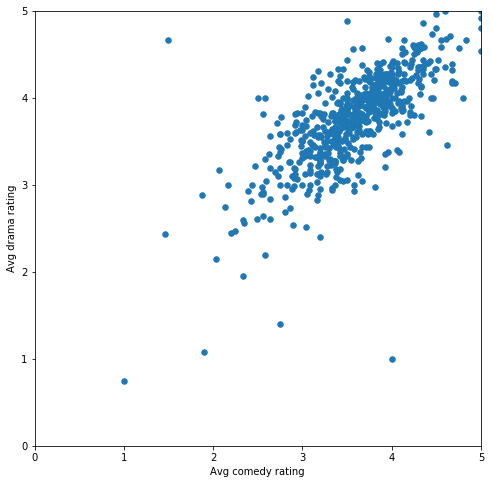

In [119]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
    
# Draw the scatterplot
draw_scatterplot(genre_ratings['avg_com_rating'],'Avg comedy rating', genre_ratings['avg_drm_rating'], 'Avg drama rating')

It looks like viewers who rated Drama highly also rated Comedy highly. Let's use clustering to see if we can find any interesting patterns. 

# Clustering
I'll use three of the clustering techniques learned in this module: Kmeans (with several different cluster sizes), mean-shift, and affinity propagation. I'll identify the number of clusters for each algorithm and plot the results.

In [111]:
from sklearn.cluster import KMeans
from sklearn import metrics

genre_ratings = genre_ratings.dropna()

n_clusters = (2, 3, 4, 6, 10, 20, 40)
for n in n_clusters:
    print("Number of estimated clusters: {}".format(n))
    model = KMeans(n_clusters=n, random_state=None).fit(genre_ratings)
    labels = model.labels_
    print(metrics.silhouette_score(genre_ratings, labels, metric='euclidean'))

Number of estimated clusters: 2
0.46841323042625055
Number of estimated clusters: 3
0.4158050493214228
Number of estimated clusters: 4
0.37771539212277605
Number of estimated clusters: 6
0.34805943421183627
Number of estimated clusters: 10
0.327162150524203
Number of estimated clusters: 20
0.3239450975352748
Number of estimated clusters: 40
0.33166642753276276


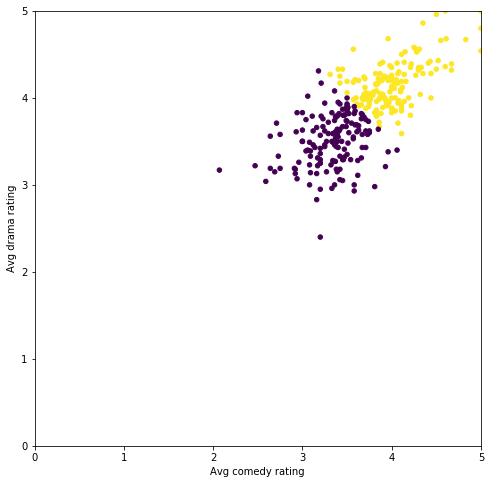

In [112]:
X = highly_rated[['avg_com_rating','avg_drm_rating']].values

# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

# Defining the cluster plotting function
def draw_clusters(highly_rated, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg comedy rating')
    ax.set_ylabel('Avg drama rating')
    clustered = pd.concat([highly_rated.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_com_rating'], clustered['avg_drm_rating'], c=clustered['group'], s=20, cmap=cmap)
# Plot
draw_clusters(highly_rated, predictions)

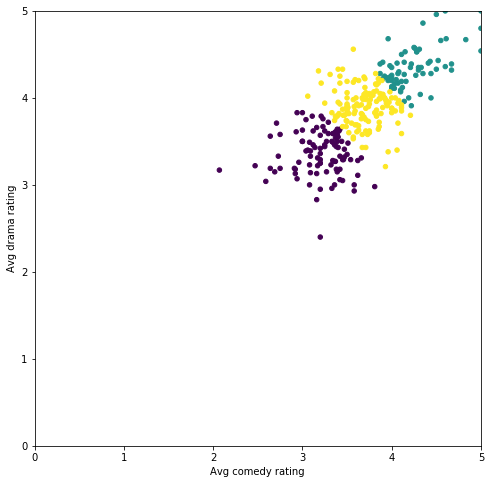

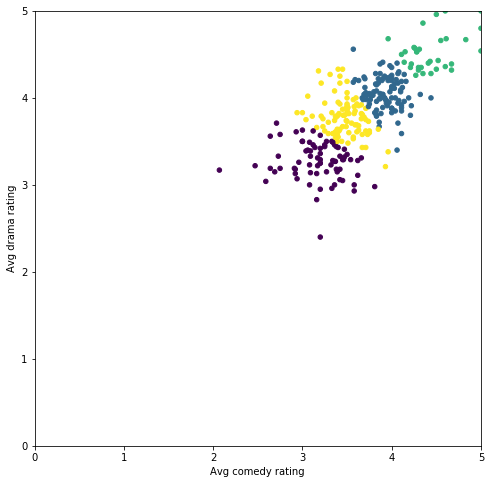

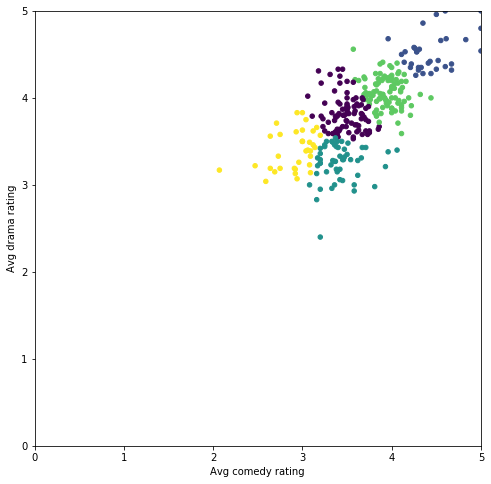

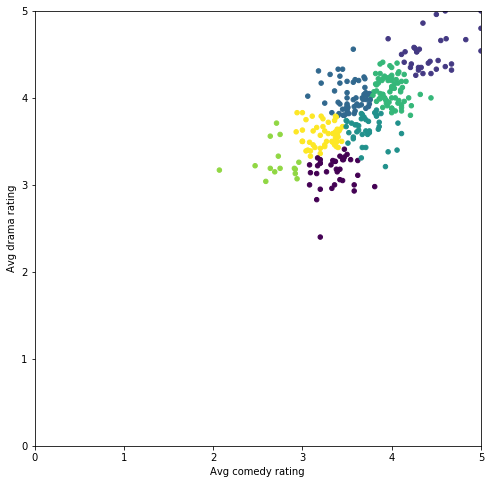

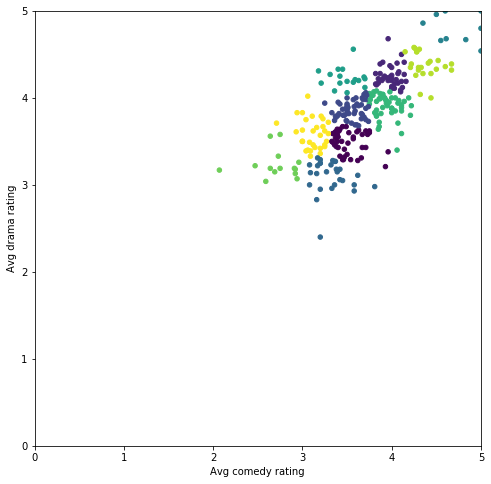

In [113]:
n_clusters = [3, 4, 5, 7, 10]
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    predictions = kmeans.fit_predict(X)
    draw_clusters(highly_rated, predictions)

# Mean Shift

In [100]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


<class 'numpy.ndarray'>


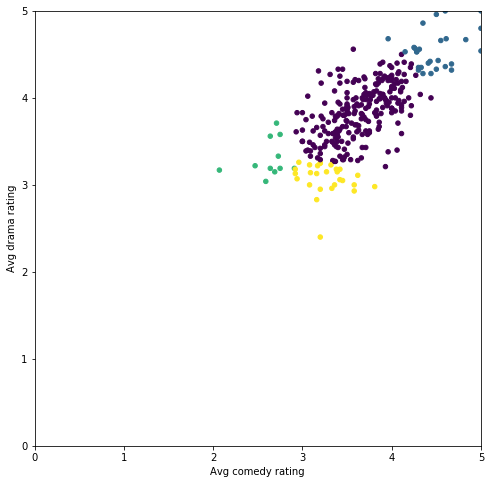

In [101]:
# Plot the clusters from the Mean-shift model
predictions = ms.fit_predict(X)
print(type(predictions))
draw_clusters(highly_rated, predictions)

In [14]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(X)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 20


<class 'numpy.ndarray'>


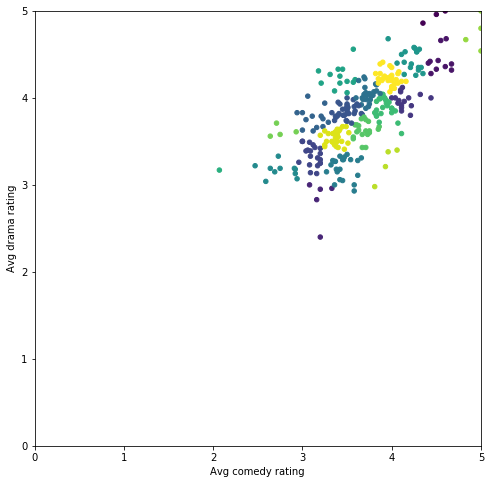

In [40]:
# Plot the clusters from the Affinity propagation model
predictions = af.fit_predict(X)
print(type(predictions))
draw_clusters(highly_rated, predictions)

# Movie Recommendation

To create a true movie-recommendation engine, we have to create clusters of user ratings and indivdual movies. First we have to combine the two dataframes so we have viewer ID, viewer ratings, and movie titles in the same dataset. For this recommendation engine, we will not use genre information. 

In [137]:
# Join the two dataframes so we have rating and genre information in the same table
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ' + str(user_movie_ratings.shape))
user_movie_ratings.head()

dataset dimensions: (610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies  
    
n_movies = 50
n_users = 50
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
most_rated_movies_users_selection.head()

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Ace Ventura: Pet Detective (1994),Memento (2000),"Mask, The (1994)",Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Dark Knight, The (2008)",Alien (1979),Beauty and the Beast (1991),Die Hard (1988),Mrs. Doubtfire (1993),Die Hard: With a Vengeance (1995)
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,2.0,5.0,4.0,4.5,4.0,5.0,3.0,5.0,3.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,3.0,3.5,3.0,4.0,4.5,4.5,4.5,4.0,2.5,3.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,3.5,4.0,4.0,3.0,NaN,5.0,3.0,3.5,4.0,3.0
273,4.5,4.5,5.0,4.0,4.0,3.0,3.5,4.5,4.5,4.0,...,4.5,4.5,4.0,4.0,4.5,4.0,3.0,4.0,3.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,2.5,4.0,3.0,5.0,5.0,2.0,4.5,3.0,3.0,3.5


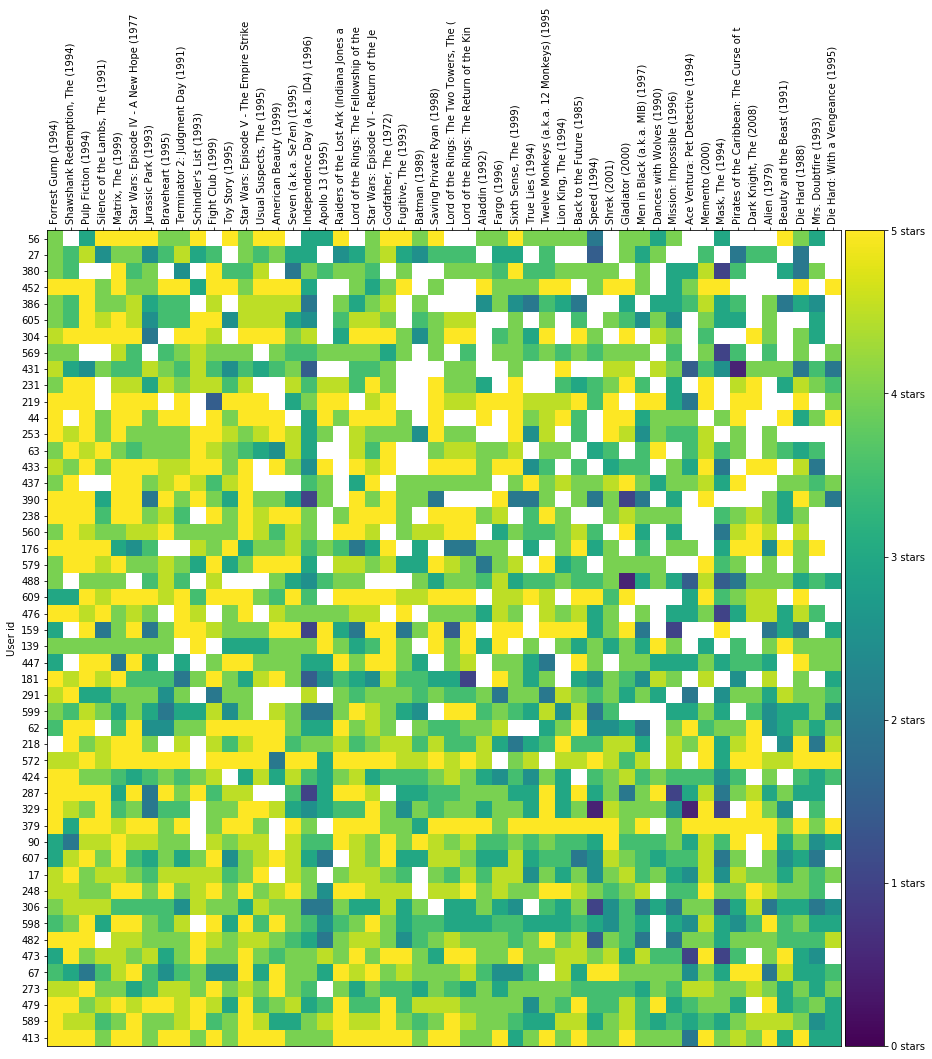

In [139]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Draw a heatmap of movie titles and corresponding viewer ratings (from gist.github.com/Rhysoshea/18f4af800179a7fa53d29194ef4dca6f)
def draw_heatmap(most_rated_movies_users_selection, axis_labels=True): 
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    fig = plt.figure(figsize=(15,15))
    ax = plt.gca()
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    ax.grid(False)
    ax.set_ylabel('User id')
    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    
draw_heatmap(most_rated_movies_users_selection)


# Clustering

For KMeans, we have to convert the data to a sparse matrix. Then we'll fit the model using different numbers of clusters and compare the resulting silhouete scores. 

In [141]:
from scipy.sparse import csr_matrix

user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_5k = get_most_rated_movies(user_movie_ratings, 5000)
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_5k).to_coo())

n_clusters = (2, 3, 4, 5, 6, 7, 8, 10, 15, 20, 40)
for n in n_clusters:
    print("Number of estimated clusters: {}".format(n))
    model = KMeans(n_clusters=n, random_state=None).fit(sparse_ratings)
    labels = model.labels_
    print(metrics.silhouette_score(sparse_ratings, labels, metric='euclidean'))

Number of estimated clusters: 2
0.3889249186609236
Number of estimated clusters: 3
0.2904431993620051
Number of estimated clusters: 4
0.27712461605384936
Number of estimated clusters: 5
-0.004423135528669212
Number of estimated clusters: 6
-0.0068644618169176
Number of estimated clusters: 7
-0.007348845039695552
Number of estimated clusters: 8
-0.0013575079793948367
Number of estimated clusters: 10
-0.005230462747321161
Number of estimated clusters: 15
0.0006254936032019162
Number of estimated clusters: 20
-0.037248889492643655
Number of estimated clusters: 40
-0.017869866591741394


The silhouette score drops off precipitously after 4 clusters. By applying the elbow method, we can identify 4 as the appropriate number of clusters. Next we'll try mean shift and affinity propagation. For mean shift, I first have to conver the sparse matrix to a dense array. 

In [77]:
# Mean-shift clustering. 

# convert array to dense array
sparse_ratings = sparse_ratings.toarray()

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(sparse_ratings, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(sparse_ratings)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


In [73]:
# Affinity Propagation clustering
af = AffinityPropagation().fit(sparse_ratings)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 149


Mean-shift and affinity propagation yielded 1 and 149 clusters, respectively. Neither of these are useful numbers for meaningfully clustering the data, so we'll use Kmeans cluster with n_clusters = 4. 

/Users/robgleich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  del sys.path[0]
/Users/robgleich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  
/Users/robgleich/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


cluster # 3
# of users in cluster: 48. # of users in plot: 48


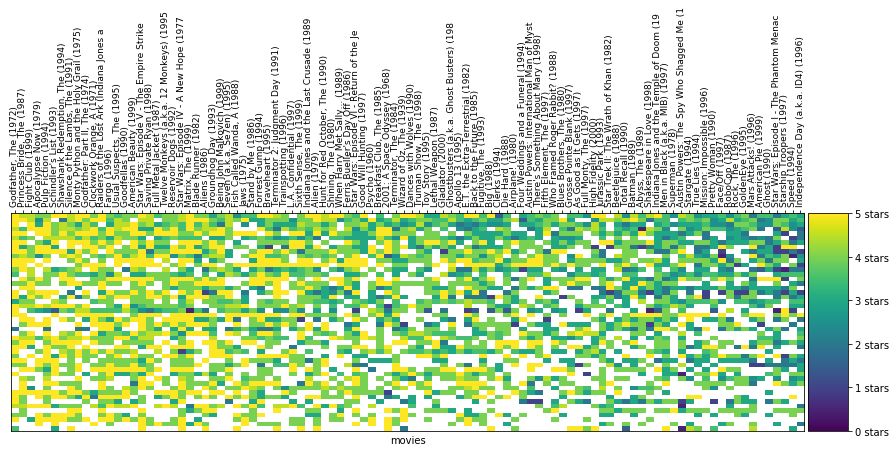

cluster # 2
# of users in cluster: 497. # of users in plot: 100


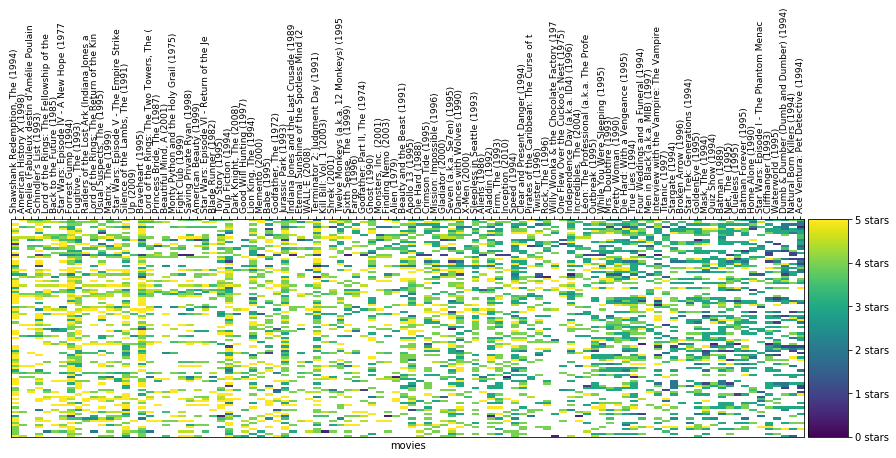

cluster # 0
# of users in cluster: 54. # of users in plot: 54


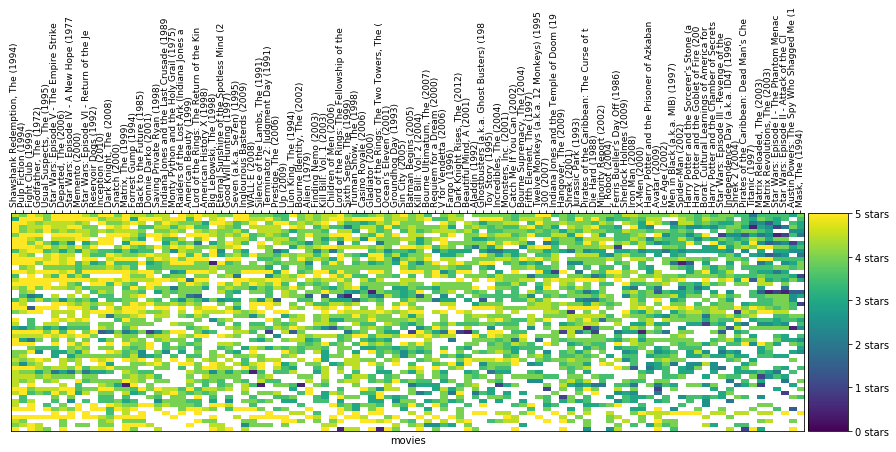

cluster # 1
# of users in cluster: 11. # of users in plot: 11


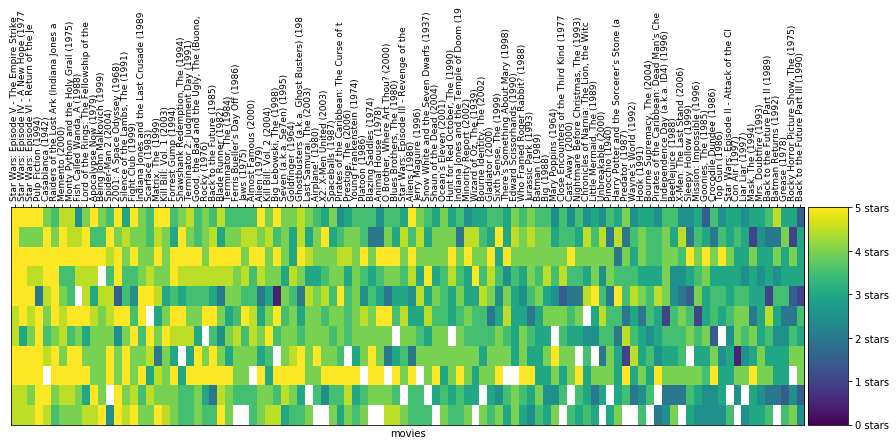

In [143]:
predictions = KMeans(n_clusters=4, algorithm='full').fit_predict(sparse_ratings)

def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()

max_users = 100
max_movies = 100

# Draw a heat map for the 4 clusters
clustered = pd.concat([most_rated_movies_5k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

Let's pick cluster 2 and generate recommendations for one of the 69 viewers in that cluster. 

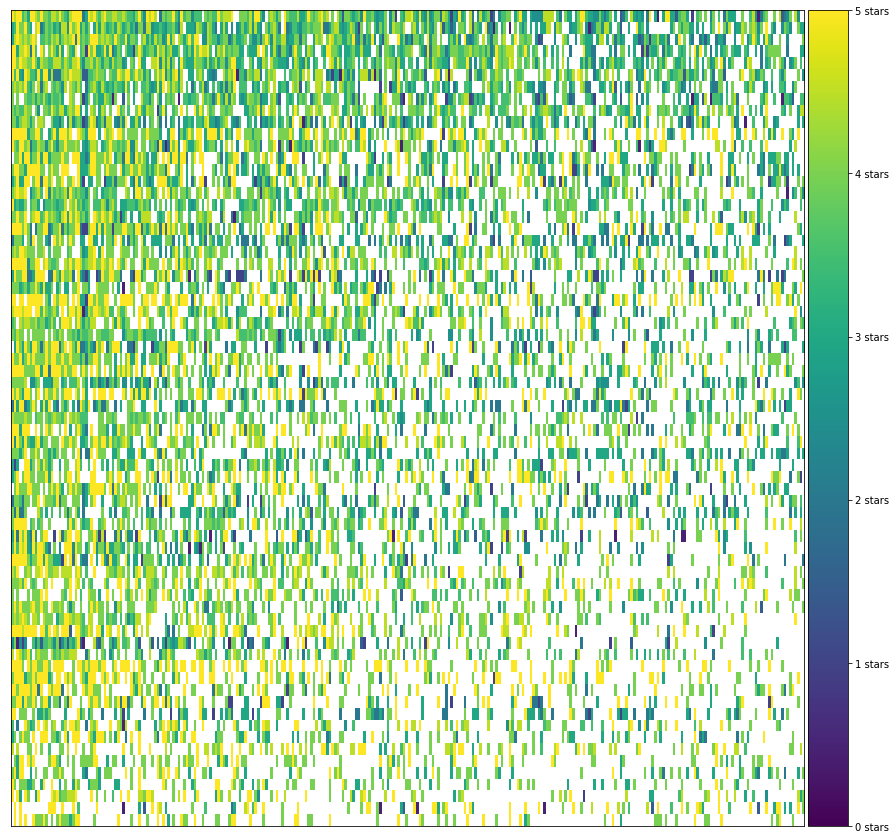

In [121]:
# Draw a heat map for cluster 2
cluster_number = 2

n_users = 69
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_heatmap(cluster, axis_labels=False)

Now we can select a blank cell in the table, indicating that the viewer hasn't rated the movie, and generate a prediction for what they will rate it based on their cluster membership.

In [124]:
print("Cluster 2:")
cluster.fillna('').head()

Cluster 2:


,Forrest Gump (1994),Star Wars: Episode IV - A New Hope (1977),"Matrix, The (1999)",Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Pulp Fiction (1994),Groundhog Day (1993),Jurassic Park (1993),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Saving Private Ryan (1998),...,Butch Cassidy and the Sundance Kid (1969),"Mask of Zorro, The (1998)",Alien: Resurrection (1997),Lethal Weapon 2 (1989),"Wedding Singer, The (1998)","American President, The (1995)","Departed, The (2006)",Go (1999),My Big Fat Greek Wedding (2002),Poltergeist (1982)
56,5,4.5,5,5,3.5,4,3,5,5,4.5,...,4.5,1.5,2,2.5,4,,4.5,2.5,,
68,3,3.5,5,4,4,5,3.5,3,,4.5,...,,2.5,4,3.5,2.5,,,4,3,3
11,3,4.5,5,4.5,4,4.5,4,4.5,5,4.5,...,4,,,2.5,,,,,,4
34,5,5,3,4.5,4.5,5,4.5,2,5,3.5,...,4,,,2,,,,,3,3
63,5,5,4,5,4.5,4.5,4,4,5,4,...,4.5,3.5,2,,2.5,3,4,,3.5,


User 68 hasn't rated Raiders of the Lost Ark, but we can use the average rating for cluster 2 to predict what score they will give the movie:

In [130]:
movie_name = "Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)"
print("Predicted rating for Raiders of the Lost Ark: " + str(cluster[movie_name].mean())[:4])

Predicted rating for Raiders of the Lost Ark: 4.28


To create a true movie recommendation engine based on user ID, we simply selected the highest rated movies in that user's cluster that they haven't rated yet:

In [135]:
#Select user ID and get ratings
user_id = 68
user_ratings  = cluster.loc[user_id, :]

# Find where their row is null, indicating movies they haven't rated yet
user_unrated_movies =  user_ratings[user_ratings.isnull()]

# Find the cluster's average rating of these movies 
avg_ratings = pd.concat([user_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Print the top ten movies
print(avg_ratings.sort_values(ascending=False)[:10])

Princess Bride, The (1987)                                                        4.410000
Lawrence of Arabia (1962)                                                         4.395833
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)                              4.360000
Platoon (1986)                                                                    4.316667
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.281818
Brazil (1985)                                                                     4.270833
Life Is Beautiful (La Vita è bella) (1997)                                        4.260870
Run Lola Run (Lola rennt) (1998)                                                  4.250000
Rear Window (1954)                                                                4.224138
Casablanca (1942)                                                                 4.210526
Name: 0, dtype: float64


We can see that user 68 hasn't seen many of the foreign and classic movies that members of their cluster rated highly. 

Such a recommendation engine provides obvious value to any media streaming service. Ideally this would take into account more than just genre and rating, and could be expanded to include many other variables such as movie lengths, time of day and frequency of viewing, viewer geographic data, search history, and average duration of viewing. All of these could be used to create more sophisticated clusters.